2.0.1+cu117
3.4155328273773193 1.7477036714553833
29.07196617126465


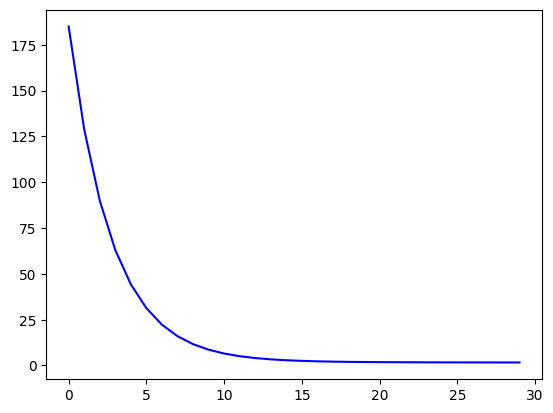

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
print(torch.__version__)

x_data = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
y1_data = torch.tensor([[6.0], [9.0], [12.0], [15.0]])
y2_data = torch.tensor([[7.0], [9.0], [13.0], [14.0]])
loss_list = []
# 创建模型
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# 损失函数和优化器
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# 模型迭代，3000次
for epoch in range(30):
    y_pre = model(x_data)
    loss = criterion(y_pre, y2_data)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch_list = numpy.arange(30)
print(model.linear.weight.item(), model.linear.bias.item())  # 输出权值和偏差
test_set = torch.tensor([[8.0]])
print(model(test_set).item())
# 可视化训练过程

plt.plot(epoch_list, loss_list, label='loss', color='blue')
plt.show()


0.3%

100.0%


Extracting ./data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw



100.0%


Extracting ./data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw



100.0%


Extracting ./data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw



100.0%

Extracting ./data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw




d:\Anaconda202309\envs\pytorch_gpu\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\Anaconda202309\envs\pytorch_gpu\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


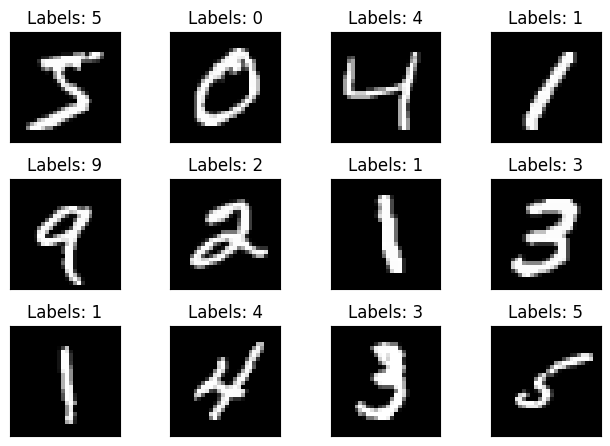

[1,   300]: loss: 0.868 , acc: 74.96 %


KeyboardInterrupt: 

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

"""
卷积运算 使用mnist数据集，和10-4，11类似的，只是这里：1.输出训练轮的acc 2.模型上使用torch.nn.Sequential
"""
# Super parameter ------------------------------------------------------------------------------------
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

# Prepare dataset ------------------------------------------------------------------------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# softmax归一化指数函数(https://blog.csdn.net/lz_peter/article/details/84574716),其中0.1307是mean均值和0.3081是std标准差

train_dataset = datasets.MNIST(root='./data/mnist', train=True, transform=transform,download=True)  # 本地没有就加上download=True
test_dataset = datasets.MNIST(root='./data/mnist', train=False, transform=transform,download=True)  # train=True训练集，=False测试集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


# 训练集乱序，测试集有序
# Design model using class ------------------------------------------------------------------------------
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层(图是先卷积后激活再池化，差别不大)
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

model = Net()

# Construct loss and optimizer ------------------------------------------------------------------------------
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量


# Train and Test CLASS --------------------------------------------------------------------------------------
# 把单独的一轮一环封装在函数类里
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

        # torch.save(model.state_dict(), './model_Mnist.pth')
        # torch.save(optimizer.state_dict(), './optimizer_Mnist.pth')


def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc


# Start train and Test --------------------------------------------------------------------------------------
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()


In [4]:
#gpu方式的mnist手写数字识别
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = True
 
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
test_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False
)
#change in here
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:200].cuda()/255.   # Tensor on GPU
test_y = test_data.test_labels[:200].cuda()
 
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Linear(32 * 7 * 7,10) #10分类的问题
 
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        x = self.out(x)
        return x
def main():
    cnn = CNN()
    cnn.cuda()
 
    optimizer = optim.Adam(cnn.parameters(),lr=LR)
    loss_func = nn.CrossEntropyLoss()
 
    for epoch in range(EPOCH):
        for step,(x,y) in enumerate(train_loader):
            b_x = Variable(x).cuda()
            b_y = Variable(y).cuda()
            output = cnn(b_x)
            loss = loss_func(output,b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % 50 == 0:
                test_output = cnn(test_x)
 
                # !!!!!!!! Change in here !!!!!!!!! #
                pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()  # move the computation in GPU
 
                accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
if __name__ == '__main__':
    main()

Epoch:  0 | train loss: 2.2969 | test accuracy: 0.16
Epoch:  0 | train loss: 0.5326 | test accuracy: 0.85
Epoch:  0 | train loss: 0.0984 | test accuracy: 0.95
Epoch:  0 | train loss: 0.3722 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1853 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0759 | test accuracy: 0.98
Epoch:  0 | train loss: 0.1037 | test accuracy: 0.99
Epoch:  0 | train loss: 0.1607 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0397 | test accuracy: 0.99
Epoch:  0 | train loss: 0.1057 | test accuracy: 0.99
Epoch:  0 | train loss: 0.2034 | test accuracy: 0.99
Epoch:  0 | train loss: 0.0881 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1900 | test accuracy: 0.99
Epoch:  0 | train loss: 0.1095 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0353 | test accuracy: 0.99
Epoch:  0 | train loss: 0.0893 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0856 | test accuracy: 0.99
Epoch:  0 | train loss: 0.2316 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0658 | test accuracy

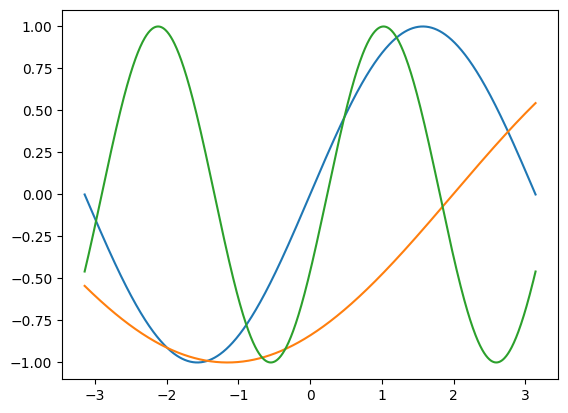

cuda


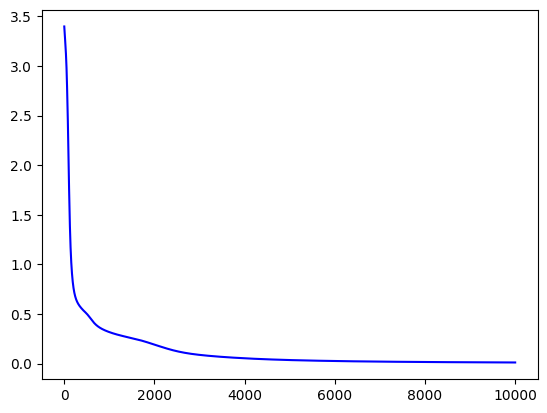

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# 准备数据
theta = np.linspace(-np.pi, np.pi, 1000)  # 创建一些 theta 值
y1 = np.sin(theta)
y2 = np.sin(theta/2+np.pi/2+10)
y3 = np.sin(2*theta+np.pi/6-1)
plt.plot(theta, y1, label='sin(theta)')
plt.plot(theta, y2, label='cos(theta)')
plt.plot(theta, y3, label='cos(theta)')
plt.show()
theta_tensor = torch.tensor(theta, dtype=torch.float32)
y1_tensor = torch.tensor(y1, dtype=torch.float32)
y2_tensor = torch.tensor(y2, dtype=torch.float32)
y3_tensor = torch.tensor(y3, dtype=torch.float32)
loss_list = []
# 创建神经网络
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 =torch.nn.Linear(3, 8)  # 输入层2个特征，隐藏层64个神经元
        self.Linear2 =torch.nn.Linear(8, 4)  # 隐藏层64个神经元，隐藏层32个神经元
        self.Linear3 =torch.nn.Linear(4, 1)  # 隐藏层32个神经元，输出层1个神经元

    def forward(self, x):
        x = torch.relu(self.Linear1(x))
        x = torch.relu(self.Linear2(x))
        x = self.Linear3(x)
        return x

model = LinearModel()
if torch.cuda.is_available():
    print("cuda")
    model = model.cuda() 
    theta_tensor = theta_tensor.cuda()
    y1_tensor = y1_tensor.cuda()
    y2_tensor = y2_tensor.cuda()
    y3_tensor = y3_tensor.cuda()
    
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练神经网络
for epoch in range(10000):
    inputs = torch.cat((y1_tensor.view(-1, 1), y2_tensor.view(-1, 1),y3_tensor.view(-1, 1)), dim=1)  # 输入为 (y1, y2)
    labels = theta_tensor.view(-1, 1)  # 目标是 theta
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

epoch_list = np.arange(epoch+1)
plt.plot(epoch_list, loss_list, label='loss', color='blue')
plt.show()
# 使用训练好的神经网络进行预测

thetalist = []
predicted_thetalist = []
for i in range(100):
    theta = (i-50) * np.pi / 100
    thetalist.append(theta)
    y1 = np.sin(theta)
    y2 = np.sin(theta/2+np.pi/2+10)
    y3 = np.sin(2*theta+np.pi/6-1)
    test_inputs = torch.tensor([[y1, y2, y3]], dtype=torch.float32)  # 用 sin(π/6) 和 cos(π/3) 进行测试
    predicted_theta = model(test_inputs)
    predicted_thetalist.append(predicted_theta.item())

plt.plot(thetalist,predicted_thetalist)
plt.plot(range(-2,3),range(-2,3))
plt.show()  